Motivation: Followed by ResNet Basicblock architecture

In [1]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score

In [2]:
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
NUM_WORKERS = 3
best_val_loss = 1e9

In [3]:
custom_transform = transforms.Compose([#transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='../data', 
                                 train=True, 
                                 transform=custom_transform,
                                 download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS,
                          drop_last=True,
                          shuffle=True)

test_dataset = datasets.CIFAR10(root='../data', 
                                train=False,
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         drop_last=False,
                         shuffle=False)

# Checking the dataset
all_train_labels = []
all_test_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)

Files already downloaded and verified


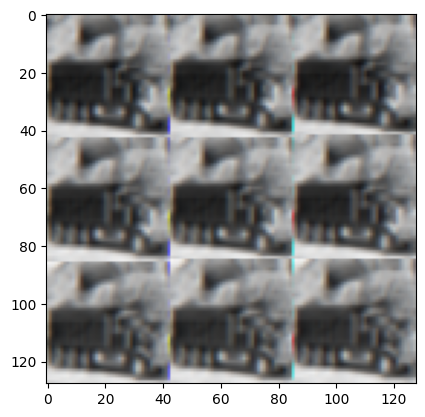

In [11]:
img = next(iter(train_loader))
plt.imshow(img[0][1].reshape(128,128,3))

In [5]:
majority_prediction = torch.argmax(torch.bincount(all_test_labels))
baseline_acc = torch.mean((all_test_labels == majority_prediction).float())
print(f'Baseline ACC: {baseline_acc*100:.2f}%')

Baseline ACC: 10.00%


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
device

'cuda'

In **ResNet-18**, the number **18** refers to the **total number of layers with learnable weights** (convolutional + fully connected layers) in the network.

Specifically:

* ResNet counts only **convolutional layers** and the **final fully connected (FC) layer**, not pooling layers or batch normalization.
* In **ResNet-18**, the architecture has:

  * **1 initial convolution layer** (7×7 conv)
  * **4 residual stages**, each with **2 residual blocks**, and each block has **2 convolution layers** → $4 \times 2 \times 2 = 16$ conv layers
  * **1 final fully connected layer**

So total = $1 + 16 + 1 = 18$ layers → hence **ResNet-18**.

👉 Similarly, ResNet-34 has 34 weighted layers, ResNet-50 has 50 (with bottleneck blocks), and so on.

In [30]:
# # Let's Go Deeper!

# import torch
# from torch import nn
# import torch.nn.functional as F

# class BottlenectBlock(nn.Module):
#     expansion = 4

#     def __init__(self, in_planes, out_channels, stride=1, downsample=None, base_width=4, cardinality=32):
#         super(BottlenectBlock, self).__init__()
#         width = int(out_channels * (base_width / 64.)) * cardinality
#         self.conv1 = nn.Conv2d(in_planes, width, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(width)
    
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
#         self.bn2 = nn.BatchNorm2d(width) 
        
#         self.conv3 = nn.Conv2d(width, out_channels*self.expansion, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        
#         self.downsample = None
#         if stride != 1 or in_planes != out_channels * self.expansion:
#             self.downsample = nn.Sequential(
#                 nn.Conv2d(in_planes, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels * self.expansion)
#             )
        

#     def forward(self, x):
#         residual = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)
        
#         out = self.conv3(out)
#         out = self.bn3(out)

#         if self.downsample is not None:
#             residual = self.downsample(x)

#         out += residual
#         out = self.relu(out)

#         return out


# class ResNet(nn.Module):

#     def __init__(self, block, layers, num_classes, grayscale, cardinality=32, base_width=4):
#         self.inplanes = 64
#         self.cardinality = cardinality
#         self.base_width = base_width
        
#         if grayscale:
#             in_dim = 1
#         else:
#             in_dim = 3
#         super(ResNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
#                                bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0], stride=1, cardinality=self.cardinality, base_width=self.base_width)
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2, cardinality=self.cardinality, base_width=self.base_width)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2, cardinality=self.cardinality, base_width=self.base_width)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2, cardinality=self.cardinality, base_width=self.base_width)
#         self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
#         self.fc = nn.Linear(2048 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, (2. / n)**.5)
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()

# #     def _make_layer(self, block, planes, blocks, stride=1):
# #         layers = []
# #         layers.append(block(self.inplanes, planes, stride))
# #         self.inplanes = planes * block.expansion
# #         for i in range(1, blocks):
# #             layers.append(block(self.inplanes, planes))

# #         return nn.Sequential(*layers)

    
#     def _make_layer(self, block, planes, blocks, cardinality, base_width, stride=1):
#         layers = []
#         for i in range(1, blocks):
#             layers.append(block(self.inplanes, planes, stride, self.cardinality, self.base_width))
#             self.inplanes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         logits = self.fc(x)
#         #probas = F.softmax(logits, dim=1)
#         return logits



# def resnet18(num_classes):
#     """Constructs a ResNet-18 model."""
#     model = ResNet(block=BottlenectBlock, 
#                    layers=[2, 2, 2, 2],
#                    num_classes=num_classes,
#                    grayscale=GRAYSCALE)
#     return model

In [53]:
# Let's Go Deeper!

import torch
from torch import nn
import torch.nn.functional as F

class BottlenectBlock(nn.Module):
    expansion = 4

    def __init__(self, in_planes, out_channels, stride=1, downsample=None):
        super(BottlenectBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
    
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) 
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.downsample = None
        if stride != 1 or in_planes != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
        

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 1024
        
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

#     def _make_layer(self, block, planes, blocks, stride=1):
#         layers = []
#         layers.append(block(self.inplanes, planes, stride))
#         self.inplanes = planes * block.expansion
#         for i in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

    
    def _make_layer(self, block, planes, blocks, stride=1):
        layers = []
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, stride))
            self.inplanes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        #probas = F.softmax(logits, dim=1)
        return logits



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BottlenectBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=num_classes,
                   grayscale=GRAYSCALE)
    return model

In [56]:
def _make_layer(block, planes, blocks, stride=1):
    inplanes = 64
    layers = []
    for i in range(1, blocks):
        layers.append(block(inplanes, planes, stride))
        inplanes = planes * block.expansion
    return nn.Sequential(*layers)

In [58]:
_make_layer(BottlenectBlock, 32, 4)

Sequential(
  (0): BottlenectBlock(
    (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BottlenectBlock(
    (conv1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inp

#### Shape testing

In [59]:
def attach_shape_hooks(model):
    """
    Attaches forward hooks to all layers of a model 
    to print input/output shapes during a forward pass.
    """
    def hook(module, inp, out):
        # skip printing for containers (Sequential, ModuleList etc.)
        if not isinstance(module, (nn.Sequential, nn.ModuleList)):
            print(f"{module.__class__.__name__:<20} "
                  f"input: {tuple(inp[0].shape)} "
                  f"output: {tuple(out.shape)}")
    
    def sep_hook(module, inp, out):
        print("\n==================\n")

    hooks = []
    for layer in model.modules():
        hooks.append(layer.register_forward_hook(hook))
        
    for name, layer_ in model.named_children():
        if "layer" in name:
            layer_.register_forward_hook(sep_hook)
    return hooks

In [60]:
img[0].shape

torch.Size([32, 3, 128, 128])

In [61]:
GRAYSCALE = False
inc = ResNet(block=BottlenectBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=10,
                   grayscale=GRAYSCALE)

In [62]:
hooks = attach_shape_hooks(inc)

In [63]:
oo = inc(img[0])

Conv2d               input: (32, 3, 128, 128) output: (32, 1024, 64, 64)
BatchNorm2d          input: (32, 1024, 64, 64) output: (32, 1024, 64, 64)
ReLU                 input: (32, 1024, 64, 64) output: (32, 1024, 64, 64)
MaxPool2d            input: (32, 1024, 64, 64) output: (32, 1024, 32, 32)
Conv2d               input: (32, 1024, 32, 32) output: (32, 64, 32, 32)
BatchNorm2d          input: (32, 64, 32, 32) output: (32, 64, 32, 32)
ReLU                 input: (32, 64, 32, 32) output: (32, 64, 32, 32)
Conv2d               input: (32, 64, 32, 32) output: (32, 64, 32, 32)
BatchNorm2d          input: (32, 64, 32, 32) output: (32, 64, 32, 32)
ReLU                 input: (32, 64, 32, 32) output: (32, 64, 32, 32)
Conv2d               input: (32, 64, 32, 32) output: (32, 256, 32, 32)
BatchNorm2d          input: (32, 256, 32, 32) output: (32, 256, 32, 32)
Conv2d               input: (32, 1024, 32, 32) output: (32, 256, 32, 32)
BatchNorm2d          input: (32, 256, 32, 32) output: (32, 256, 32,

In [51]:
for h in hooks:
    h.remove()

#### ----------------------------------------------------------------------------------

In [52]:
model = resnet18(num_classes=10)
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

8.097866 M parameters


In [18]:
for ep in range(NUM_EPOCHS):
    all_pred_labels = []
    trl = 0
    m.train()
    for x_b, y_b in train_loader:
        x_b = x_b.to(device)
        y_b = y_b.to(device)
        logits = m(x_b)
        loss = F.cross_entropy(logits, y_b)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        trl += loss.item()
    
    m.eval()
    with torch.no_grad():
        vdl = 0
        for x_v_b, y_v_b in test_loader:
            x_v_b, y_v_b = x_v_b.to(device), y_v_b.to(device)
            logits = m(x_v_b)
            loss = F.cross_entropy(logits, y_v_b)
            vdl += loss.item()
        print(f'epoch {ep} | train_loss: {trl/len(train_loader):.4f} valid_loss: {vdl/len(test_loader):.4f}')
    
    if vdl < best_val_loss:
        best_val_loss = vdl
        for x_v_b, y_v_b in test_loader:
            x_v_b, y_v_b = x_v_b.to(device), y_v_b.to(device)
            logits = m(x_v_b)
            pred_label = F.softmax(logits,dim=-1).argmax(dim=-1)
            all_pred_labels.extend(list(pred_label.detach().cpu().flatten().numpy()))
        print("Accuracy: ",accuracy_score(all_test_labels.detach().cpu().flatten().numpy(), all_pred_labels))

KeyboardInterrupt: 

In [ ]:
## 